<a href="https://colab.research.google.com/github/fkhandley/msds6925/blob/main/MSDS6825_practicum_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import MinMaxScaler
import time

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dtype_dict = {
    'order_id': 'string',
    'user_id': 'string',
    'payment_method': 'category',
    'user_zipcode_current': 'category',
    'gender': 'category',
    'product_category': 'category',
    'strain_type': 'category'
}

In [4]:
orders_load = pd.read_csv('/content/drive/MyDrive/orders.csv', dtype=dtype_dict)

In [5]:
orders_load['delivery_datetime'] = pd.to_datetime(orders_load['delivery_datetime'])

In [6]:
user_orders = orders_load.groupby('user_id').size().reset_index(name='order_count')
print(f"Original number of unique users: {len(user_orders)}")
user_orders5 = user_orders[user_orders['order_count'] >= 5]
print(f"Users with 5+ orders: {len(user_orders5)}")
users5 = user_orders5['user_id'].unique()
user_size = round(len(users5)*0.5,0)
print(f"Taking sample of {user_size} users")
user_sample = np.random.choice(users5, size=int(user_size), replace=False)
orders_load = orders_load[orders_load['user_id'].isin(user_sample)]
final_orders_per_user = orders_load.groupby('user_id').size()
print("\nFinal orders per user:")
print(final_orders_per_user.describe())

Original number of unique users: 884901
Users with 5+ orders: 265985
Taking sample of 132992.0 users

Final orders per user:
count    132992.000000
mean         20.944929
std          27.721531
min           5.000000
25%           7.000000
50%          11.000000
75%          23.000000
max         696.000000
dtype: float64


In [7]:
freq_df = orders_load[['order_id','user_id','delivery_datetime']].copy()
freq_df.drop_duplicates('order_id', inplace=True)
freq_df.sort_values('delivery_datetime', inplace=True)

# Create the shifted dates within each user group
freq_df['last_delivery_date'] = freq_df.groupby('user_id')['delivery_datetime'].shift(1)

# Calculate the days between orders
freq_df['days_since_order'] = (freq_df['delivery_datetime'] - freq_df['last_delivery_date']).dt.days

In [8]:
orders_load = orders_load.merge(freq_df[['order_id','days_since_order']], on='order_id', how='left')

In [9]:
del freq_df

# Key input: days of orders lookback

In [10]:
end_date = orders_load['delivery_datetime'].max()
#start_date = end_date - timedelta(days=4500000)

#orders_reduced = orders_load[orders_load['delivery_datetime']>=start_date]
orders_reduced = orders_load.copy()

In [11]:
del orders_load

In [12]:
users_load = pd.read_csv('/content/drive/MyDrive/users.csv', dtype=dtype_dict)

In [13]:
orders = orders_reduced.merge(users_load, on='user_id', how='left')

In [14]:
del users_load, orders_reduced

In [15]:
#items_load = pd.read_csv('/content/drive/MyDrive/items.csv', dtype=dtype_dict)
#items_load.drop('user_id', inplace=True, axis=1)

In [16]:
#category_map = {'Accessories':'other',
#                'Drops':'other',
#                'Concentrates':'other',
#                'Topicals':'other',
#                'Prerolls':'prerolls',
#                'Vaporizers':'vaporizers',
#                'Flowers':'flower',
#                'Edibles':'edibles'}

#items_load['product_category'] = items_load['product_category'].map(category_map)

In [17]:
#items_groupby = items_load.groupby(['order_id','product_category']).agg({'quantity':'sum'}).reset_index()

#reshaped_items = (items_groupby.pivot(index='order_id',columns='product_category',values=['quantity']).reset_index())

In [18]:
#reshaped_items.columns = reshaped_items.columns.droplevel(0)
#reshaped_items = reshaped_items.reset_index()
#reshaped_items = reshaped_items.rename(columns={'': 'order_id'})


#reshaped_items.head()

In [19]:
#reshaped = reshaped_items[['order_id','edibles','flower','prerolls','vaporizers']]
#reshaped.head()

In [20]:
#orders = orders.merge(reshaped, on='order_id', how='left')

In [21]:
orders = orders.drop('promo_code', axis=1)
orders['account_created_at'] = pd.to_datetime(orders['account_created_at'])
orders['birthdate'] = pd.to_datetime(orders['birthdate'])

In [22]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2785508 entries, 0 to 2785507
Data columns (total 12 columns):
 #   Column                Dtype         
---  ------                -----         
 0   order_id              string        
 1   user_id               string        
 2   delivery_datetime     datetime64[ns]
 3   wait_time             float64       
 4   promo_credit          float64       
 5   order_price_total     float64       
 6   payment_method        category      
 7   days_since_order      float64       
 8   user_zipcode_current  category      
 9   account_created_at    datetime64[ns]
 10  birthdate             datetime64[ns]
 11  gender                category      
dtypes: category(3), datetime64[ns](3), float64(4), string(2)
memory usage: 203.1 MB


In [23]:
#del items_load, items_groupby, reshaped_items, reshaped

In [24]:
orders['age_at_purchase'] = round(orders.delivery_datetime.dt.year - orders.birthdate.dt.year)

orders['account_age_at_purchase'] =  (orders.delivery_datetime.dt.year - orders.account_created_at.dt.year)*12+orders.delivery_datetime.dt.month - orders.account_created_at.dt.month

In [25]:
#orders['weekday'] = orders.delivery_datetime.dt.dayofweek
#orders['hour'] = orders.delivery_datetime.dt.hour
#orders['month'] = orders.delivery_datetime.dt.month

In [26]:
#payment_map = {'POB':'card',
#               'ACH':'ach',
#               'Cash':'cash',
#               'Pin Debit':'card',
#               'Online Debit':'card',
#               'Account Credit':'promotion'}

#orders.payment_method = orders.payment_method.map(payment_map)

In [27]:
#orders['is_payment_ach'] = (orders['payment_method'] == 'ach').astype(int)
#orders['is_payment_card'] = (orders['payment_method'] == 'card').astype(int)
#orders['is_payment_cash'] = (orders['payment_method'] == 'cash').astype(int)
#orders['is_payment_promotion'] = (orders['payment_method'] == 'promotion').astype(int)

In [28]:
#orders['is_male'] = (orders['gender'] == 'Male').astype(int)
#orders['is_female'] = (orders['gender'] == 'Female').astype(int)

In [29]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2785508 entries, 0 to 2785507
Data columns (total 14 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   order_id                 string        
 1   user_id                  string        
 2   delivery_datetime        datetime64[ns]
 3   wait_time                float64       
 4   promo_credit             float64       
 5   order_price_total        float64       
 6   payment_method           category      
 7   days_since_order         float64       
 8   user_zipcode_current     category      
 9   account_created_at       datetime64[ns]
 10  birthdate                datetime64[ns]
 11  gender                   category      
 12  age_at_purchase          float64       
 13  account_age_at_purchase  int64         
dtypes: category(3), datetime64[ns](3), float64(5), int64(1), string(2)
memory usage: 245.6 MB


In [30]:
fill_values = {
    'wait_time': orders['wait_time'].mean(),
    'days_since_order': 0,
#    'avg_freq': orders['avg_freq'].mean(),
    'edibles': 0,
    'flower': 0,
    'prerolls': 0,
    'vaporizers': 0,
    'age_at_purchase': orders['age_at_purchase'].mean()
    }

orders = orders.fillna(fill_values)

In [31]:
orders_final = orders.drop(['order_id','account_created_at','birthdate','gender','payment_method','wait_time'], axis=1).copy()

In [32]:
orders_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2785508 entries, 0 to 2785507
Data columns (total 8 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   user_id                  string        
 1   delivery_datetime        datetime64[ns]
 2   promo_credit             float64       
 3   order_price_total        float64       
 4   days_since_order         float64       
 5   user_zipcode_current     category      
 6   age_at_purchase          float64       
 7   account_age_at_purchase  int64         
dtypes: category(1), datetime64[ns](1), float64(4), int64(1), string(1)
memory usage: 155.3 MB


In [33]:
user_count = orders_final.user_id.nunique()
user_count

132992

# Deep Learning START

In [34]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        # Configure GPU memory growth
        for gpu in physical_devices:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled")

        # Set mixed precision policy
        tf.keras.mixed_precision.set_global_policy('mixed_float16')
        print("Mixed precision policy set to float16")
    except RuntimeError as e:
        print(e)

Num GPUs Available:  1
GPU memory growth enabled
Mixed precision policy set to float16


In [35]:
# Before calling create_batch_sequences:
print("Data check:")
user_counts = orders_final.groupby('user_id').size()
print("\nOrder counts distribution:")
print(user_counts.describe())
print(f"\nUsers with 5+ orders: {sum(user_counts >= 5)}")
print(f"Min orders for a user: {user_counts.min()}")
print(f"Max orders for a user: {user_counts.max()}")

Data check:

Order counts distribution:
count    132992.000000
mean         20.944929
std          27.721531
min           5.000000
25%           7.000000
50%          11.000000
75%          23.000000
max         696.000000
dtype: float64

Users with 5+ orders: 132992
Min orders for a user: 5
Max orders for a user: 696


In [36]:
# Before running create_batch_sequences:
df=orders_final
print("Date range of data:")
print(f"Start: {df['delivery_datetime'].min()}")
print(f"End: {df['delivery_datetime'].max()}")
print(f"Days spanned: {(df['delivery_datetime'].max() - df['delivery_datetime'].min()).days}")

Date range of data:
Start: 2020-01-01 00:00:18.240000
End: 2025-01-25 18:05:26.783000
Days spanned: 1851


In [78]:
class OrderSequenceGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, sequence_length=10, min_orders=5, batch_size=32, user_sample_fraction=0.02):
        self.df = df
        self.sequence_length = sequence_length
        self.min_orders = min_orders
        self.batch_size = batch_size

        # Group by user and filter for users with minimum orders
        self.user_orders = {}
        user_counts = df.groupby('user_id').size()
        valid_users = user_counts[user_counts >= min_orders].index.tolist()

        # Take a sample of users for faster processing
        sample_size = max(100, int(len(valid_users) * user_sample_fraction))
        self.users = np.random.choice(valid_users, sample_size, replace=False)

        # Cache user data
        for user_id in self.users:
            self.user_orders[user_id] = df[df['user_id'] == user_id].sort_values('delivery_datetime')

        # Calculate total number of sequences
        self.sequence_indices = self._calculate_sequence_indices()
        self.steps = len(self.sequence_indices) // batch_size

    def _calculate_sequence_indices(self):
        """Pre-calculate all valid (user_id, start_idx) pairs"""
        sequence_indices = []
        for user_id in self.users:
            user_data = self.user_orders[user_id]
            # Use 80% for training
            train_size = int(len(user_data) * 0.8)
            train_data = user_data.iloc[:train_size]

            if len(train_data) >= self.sequence_length:
                for i in range(len(train_data) - self.sequence_length + 1):
                    sequence_indices.append((user_id, i))

        return sequence_indices

    def __len__(self):
        return max(1, len(self.sequence_indices) // self.batch_size)

    def __getitem__(self, idx):
        start_idx = idx * self.batch_size
        end_idx = min((idx + 1) * self.batch_size, len(self.sequence_indices))
        batch_indices = self.sequence_indices[start_idx:end_idx]

        batch_sequences = []
        batch_labels = []

        for user_id, seq_start in batch_indices:
            sequence, label = self._create_sequence(user_id, seq_start)
            if sequence is not None:
                batch_sequences.append(sequence)
                batch_labels.append(label)

        # Pad batch if needed
        if len(batch_sequences) < self.batch_size:
            pad_size = self.batch_size - len(batch_sequences)
            feature_dim = len(self.get_feature_names()) + 1  # +1 for sequence frequency
            batch_sequences.extend([np.zeros((self.sequence_length, feature_dim))] * pad_size)
            batch_labels.extend([0] * pad_size)

        return np.array(batch_sequences), np.array(batch_labels)

    def get_feature_names(self):
        return [
            'days_since_order',
            'order_price_total',
            'promo_credit',
            'account_age_at_purchase'
        ]

    def _create_sequence(self, user_id, start_idx):
        user_data = self.user_orders[user_id]
        sequence_data = user_data.iloc[start_idx:start_idx + self.sequence_length]

        if len(sequence_data) < self.sequence_length:
            return None, None

        # Calculate average frequency
        days_between = sequence_data['days_since_order'].dropna()
        if len(days_between) == 0:
            return None, None

        seq_freq = days_between.mean()
        features = self.get_feature_names()

        # Build sequence
        sequence = np.zeros((self.sequence_length, len(features) + 1))
        for j, order in enumerate(sequence_data.itertuples()):
            sequence[j, :-1] = [getattr(order, feat) for feat in features]
            sequence[j, -1] = seq_freq

        # Calculate label (order within next 7 days)
        last_order_date = sequence_data.iloc[-1]['delivery_datetime']
        next_week = last_order_date + pd.Timedelta(days=7)

        # Check for future orders
        future_order = user_data[
            (user_data['delivery_datetime'] > last_order_date) &
            (user_data['delivery_datetime'] <= next_week)
        ]

        label = 1 if len(future_order) > 0 else 0
        return sequence, label

    def on_epoch_end(self):
        # Shuffle sequence indices
        np.random.shuffle(self.sequence_indices)

In [79]:
class ValidationGenerator(OrderSequenceGenerator):
    def __init__(self, df, sequence_length=10, min_orders=5, batch_size=32, user_sample_fraction=0.02):
        super().__init__(df, sequence_length, min_orders, batch_size, user_sample_fraction)

    def _calculate_sequence_indices(self):
        """Calculate validation sequence indices using the last 20% of each user's data"""
        sequence_indices = []
        for user_id in self.users:
            user_data = self.user_orders[user_id]
            # Use last 20% for validation
            train_size = int(len(user_data) * 0.8)
            val_data = user_data.iloc[train_size:]

            if len(val_data) >= self.sequence_length:
                for i in range(len(val_data) - self.sequence_length + 1):
                    sequence_indices.append((user_id, train_size + i))

        return sequence_indices

    def _create_sequence(self, user_id, start_idx):
        user_data = self.user_orders[user_id]
        sequence_data = user_data.iloc[start_idx:start_idx + self.sequence_length]

        if len(sequence_data) < self.sequence_length:
            return None, None

        # Calculate average frequency
        days_between = sequence_data['days_since_order'].dropna()
        if len(days_between) == 0:
            return None, None

        seq_freq = days_between.mean()
        features = self.get_feature_names()

        # Build sequence
        sequence = np.zeros((self.sequence_length, len(features) + 1))
        for j, order in enumerate(sequence_data.itertuples()):
            sequence[j, :-1] = [getattr(order, feat) for feat in features]
            sequence[j, -1] = seq_freq

        # Calculate label (order within next 7 days)
        last_order_date = sequence_data.iloc[-1]['delivery_datetime']
        next_week = last_order_date + pd.Timedelta(days=7)

        # IMPORTANT FIX: Only look at validation period data for future orders
        train_size = int(len(user_data) * 0.8)
        val_data = user_data.iloc[train_size:]  # Only use validation period

        future_order = val_data[
            (val_data['delivery_datetime'] > last_order_date) &
            (val_data['delivery_datetime'] <= next_week)
        ]

        label = 1 if len(future_order) > 0 else 0
        return sequence, label

In [80]:
def create_lstm_model(sequence_length, n_features):
    model = models.Sequential([
        # Input layer
        layers.Input(shape=(sequence_length, n_features)),

        # First LSTM layer with increased regularization
        layers.LSTM(64, return_sequences=True,
                   kernel_regularizer=tf.keras.regularizers.L2(0.01),
                   recurrent_regularizer=tf.keras.regularizers.L2(0.01)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),  # Increased dropout

        # Second LSTM layer
        layers.LSTM(32, return_sequences=True,
                   kernel_regularizer=tf.keras.regularizers.L2(0.01)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        # Final LSTM layer
        layers.LSTM(16),
        layers.BatchNormalization(),
        layers.Dropout(0.15),

        # Dense layers with reduced complexity
        layers.Dense(16, activation='relu',
                    kernel_regularizer=tf.keras.regularizers.L2(0.01)),
        layers.BatchNormalization(),
        layers.Dropout(0.15),

        # Output layer
        layers.Dense(1, activation='sigmoid')
    ])

    # Compile with modified learning rate and added clipnorm
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=0.0005,  # Reduced learning rate
        clipnorm=1.0  # Gradient clipping
    )

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )

    return model

In [81]:
def train_model(df, sequence_length=10, batch_size=64, epochs=100):
    print("Starting training preparation...")

    # Split users into train and validation
    unique_users = df['user_id'].unique()
    np.random.seed(42)  # For reproducibility
    val_size = int(round(len(unique_users) * 0.2, 0))
    val_users = np.random.choice(unique_users, size=val_size, replace=False)
    train_users = [u for u in unique_users if u not in val_users]

    train_df = df[df['user_id'].isin(train_users)]
    val_df = df[df['user_id'].isin(val_users)]

    print(f"Training set users: {len(train_df['user_id'].unique())}")
    print(f"Validation set users: {len(val_df['user_id'].unique())}")

    # Create generators with progress tracking
    print("Preparing training generator...")
    start_time = time.time()
    train_generator = OrderSequenceGenerator(
        train_df,
        sequence_length=sequence_length,
        batch_size=batch_size,
    )
    print(f"Training generator ready in {time.time() - start_time:.2f} seconds")
    print(f"Training steps per epoch: {len(train_generator)}")

    print(f"Calculating training weights")
    pos_count = sum(1 for user_id, start_idx in train_generator.sequence_indices
                if train_generator._create_sequence(user_id, start_idx)[1] == 1)
    neg_count = len(train_generator.sequence_indices) - pos_count
    total = pos_count + neg_count

    # Create weight dictionary (higher weight for minority class)
    class_weights = {
        0: 1.0,
        1: (neg_count / pos_count) if pos_count > 0 else 9.0  # Fallback if no positives
        }
    print(f"Class weight set at:{class_weights}")

    print("Preparing validation generator...")
    start_time = time.time()
    val_generator = ValidationGenerator(
        val_df,
        sequence_length=sequence_length,
        batch_size=batch_size
    )
    print(f"Validation generator ready in {time.time() - start_time:.2f} seconds")
    print(f"Validation steps per epoch: {len(val_generator)}")

    # Get feature dimensionality
    n_features = len(train_generator.get_feature_names()) + 1  # +1 for sequence frequency

    # Create model
    print(f"Creating LSTM model with {sequence_length} sequence length and {n_features} features...")
    model = create_lstm_model(sequence_length, n_features)

    # Add callbacks for early stopping and learning rate reduction, but no model saving
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            verbose=1
        ),
        tf.keras.callbacks.TensorBoard(
            log_dir=f'./logs/lstm_model_{int(time.time())}',
            histogram_freq=1
        )
    ]

    # Train the model
    print(f"Starting training for {epochs} epochs...")
    start_time = time.time()
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )

    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

    # Return model and history without saving
    return model, history

In [82]:
# Run the training
model, history = train_model(orders_final)

Starting training preparation...
Training set users: 106394
Validation set users: 26598
Preparing training generator...
Training generator ready in 432.21 seconds
Training steps per epoch: 316
Calculating training weights
Class weight set at:{0: 1.0, 1: 2.1503339027799346}
Preparing validation generator...
Validation generator ready in 33.59 seconds
Validation steps per epoch: 7
Creating LSTM model with 10 sequence length and 5 features...
Starting training for 100 epochs...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
316/316 ━━━━━━━━━━━━━━━━━━━━ 48s 130ms/step - accuracy: 0.6809 - auc: 0.7479 - loss: 2.1237 - precision: 0.4986 - recall: 0.7112 - val_accuracy: 0.7411 - val_auc: 0.8125 - val_loss: 1.0887 - val_precision: 0.4481 - val_recall: 0.6900 - learning_rate: 5.0000e-04
Epoch 2/100
316/316 ━━━━━━━━━━━━━━━━━━━━ 41s 130ms/step - accuracy: 0.7409 - auc: 0.8113 - loss: 1.2053 - precision: 0.5716 - recall: 0.7410 - val_accuracy: 0.7857 - val_auc: 0.8057 - val_loss: 0.7664 - val_precision: 0.5242 - val_recall: 0.6373 - learning_rate: 5.0000e-04
Epoch 3/100
316/316 ━━━━━━━━━━━━━━━━━━━━ 40s 128ms/step - accuracy: 0.7591 - auc: 0.8348 - loss: 0.9626 - precision: 0.5898 - recall: 0.7620 - val_accuracy: 0.8147 - val_auc: 0.8239 - val_loss: 0.6451 - val_precision: 0.5905 - val_recall: 0.6078 - learning_rate: 5.0000e-04
Epoch 4/100
316/316 ━━━━━━━━━━━━━━━━━━━━ 42s 132ms/step - accuracy: 0.7682 - auc: 0.8467 - loss: 0.8559 - precision: 0.6054 - recall: 0.7699 - val_accuracy: 0.7009 - val_auc: 0.8

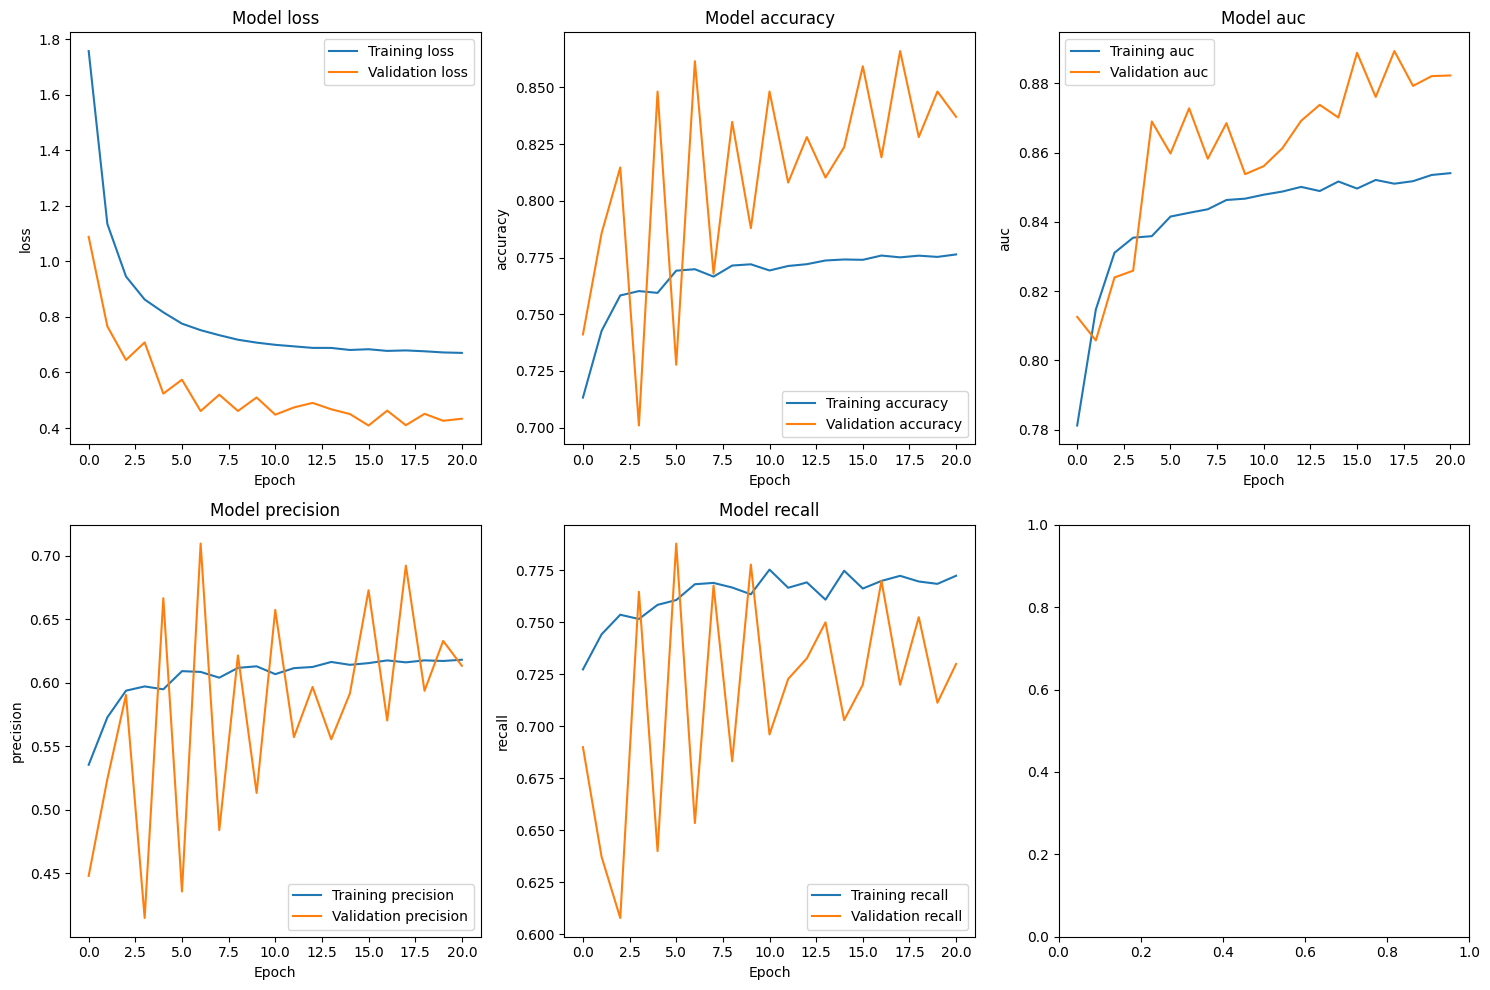


Final Training Metrics:
Loss: 0.6706
Accuracy: 0.7764
AUC: 0.8540
Precision: 0.6182
Recall: 0.7724

Final Validation Metrics:
Loss: 0.4334
Accuracy: 0.8371
AUC: 0.8823
Precision: 0.6134
Recall: 0.7300


In [83]:
# Plot the training results
def plot_training_metrics(history):
    metrics = ['loss', 'accuracy', 'auc', 'precision', 'recall']
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()

    for idx, metric in enumerate(metrics):
        if idx >= len(axes):
            break

        axes[idx].plot(history.history[metric], label=f'Training {metric}')
        axes[idx].plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
        axes[idx].set_title(f'Model {metric}')
        axes[idx].set_xlabel('Epoch')
        axes[idx].set_ylabel(metric)
        axes[idx].legend()

    plt.tight_layout()
    plt.show()

# Plot the results
plot_training_metrics(history)

# Print final metrics
final_epoch = len(history.history['loss']) - 1
print("\nFinal Training Metrics:")
print(f"Loss: {history.history['loss'][final_epoch]:.4f}")
print(f"Accuracy: {history.history['accuracy'][final_epoch]:.4f}")
print(f"AUC: {history.history['auc'][final_epoch]:.4f}")
print(f"Precision: {history.history['precision'][final_epoch]:.4f}")
print(f"Recall: {history.history['recall'][final_epoch]:.4f}")

print("\nFinal Validation Metrics:")
print(f"Loss: {history.history['val_loss'][final_epoch]:.4f}")
print(f"Accuracy: {history.history['val_accuracy'][final_epoch]:.4f}")
print(f"AUC: {history.history['val_auc'][final_epoch]:.4f}")
print(f"Precision: {history.history['val_precision'][final_epoch]:.4f}")
print(f"Recall: {history.history['val_recall'][final_epoch]:.4f}")

In [84]:
import matplotlib.pyplot as plt
import os

# Create directory for saving plots if it doesn't exist
def create_plots_directory(directory='presentation_plots'):
    if not os.path.exists(directory):
        os.makedirs(directory)
    return directory

# Plot and save training metrics
def plot_training_metrics(history, save_dir='presentation_plots', dpi=300):
    metrics = ['loss', 'accuracy', 'auc', 'precision', 'recall']
    save_dir = create_plots_directory(save_dir)

    # Create individual plots for each metric with transparent background
    for idx, metric in enumerate(metrics):
        plt.figure(figsize=(8, 6))

        # Set figure with transparent background
        fig = plt.gcf()
        fig.patch.set_alpha(0.0)

        # Plot training and validation metrics
        plt.plot(history.history[metric], label=f'Training {metric}', linewidth=2)
        plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}', linewidth=2)

        # Set title and labels
        plt.title(f'Model {metric.capitalize()}', fontsize=14, fontweight='bold')
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel(metric.capitalize(), fontsize=12)
        plt.legend(fontsize=10)
        plt.grid(True, linestyle='--', alpha=0.7)

        # Set transparent axes background
        ax = plt.gca()
        ax.patch.set_alpha(0.0)

        # Save the plot with transparent background
        filename = os.path.join(save_dir, f'{metric}_plot.png')
        plt.savefig(filename, dpi=dpi, bbox_inches='tight', transparent=True)
        plt.close()

    # Create a summary figure with all metrics
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()

    # Set figure with transparent background
    fig.patch.set_alpha(0.0)

    for idx, metric in enumerate(metrics):
        if idx >= len(axes):
            break

        axes[idx].plot(history.history[metric], label=f'Training {metric}', linewidth=2)
        axes[idx].plot(history.history[f'val_{metric}'], label=f'Validation {metric}', linewidth=2)
        axes[idx].set_title(f'Model {metric.capitalize()}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Epoch', fontsize=10)
        axes[idx].set_ylabel(metric.capitalize(), fontsize=10)
        axes[idx].legend(fontsize=8)
        axes[idx].grid(True, linestyle='--', alpha=0.7)

        # Set transparent axes background
        axes[idx].patch.set_alpha(0.0)

    plt.tight_layout()

    # Save the summary figure
    summary_filename = os.path.join(save_dir, 'all_metrics_summary.png')
    plt.savefig(summary_filename, dpi=dpi, bbox_inches='tight', transparent=True)
    plt.close()

    print(f"All plots saved to '{save_dir}' directory with transparent backgrounds")

    # Print final metrics in a summary table
    final_epoch = len(history.history['loss']) - 1

    print("\nFinal Training Metrics:")
    for metric in metrics:
        print(f"{metric.capitalize()}: {history.history[metric][final_epoch]:.4f}")

    print("\nFinal Validation Metrics:")
    for metric in metrics:
        print(f"{metric.capitalize()}: {history.history[f'val_{metric}'][final_epoch]:.4f}")

    return save_dir

# Example usage:
plot_training_metrics(history, save_dir='presentation_plots', dpi=300)

All plots saved to 'presentation_plots' directory with transparent backgrounds

Final Training Metrics:
Loss: 0.6706
Accuracy: 0.7764
Auc: 0.8540
Precision: 0.6182
Recall: 0.7724

Final Validation Metrics:
Loss: 0.4334
Accuracy: 0.8371
Auc: 0.8823
Precision: 0.6134
Recall: 0.7300


'presentation_plots'